In [ ]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.2/934.2 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.7/314.7 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.5/273.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 891.4/891.4 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 1.6 MB/s eta 0:00:00
   ━

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

file_path = '/content/drive/MyDrive/Capstone/Outliers_Removed_with_IsolationForest.csv'
df = pd.read_csv(file_path)

In [ ]:
from darts import TimeSeries
from darts.utils.missing_values import fill_missing_values
from darts.models import RNNModel, ExponentialSmoothing
from darts.metrics import mae, rmse
import matplotlib.pyplot as plt

# Preprocess the data
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df_co = df[['Timestamp', 'RH (%)']].dropna()

# Remove duplicates by averaging values for duplicate timestamps
df_co_cleaned = df_co.groupby('Timestamp').mean().reset_index()

# Create the TimeSeries object
co_series = TimeSeries.from_dataframe(df_co_cleaned, time_col='Timestamp', value_cols='RH (%)', fill_missing_dates=True, freq='h')
co_series_filled = fill_missing_values(co_series)

# Split the data into train and validation sets
train, val = co_series_filled.split_before(0.8)

# LSTM
lstm_model = RNNModel(
    model='LSTM',
    input_chunk_length=20,
    output_chunk_length=1,
    n_epochs=100,
    random_state=42
)
lstm_model.fit(train)

# Exponential Smoothing
exp_model = ExponentialSmoothing()
exp_model.fit(train)

# Both predictions on the validation set
lstm_prediction = lstm_model.predict(len(val), series=train)
exp_prediction = exp_model.predict(len(val))

# Ensembling LSTM and Exponential
w1 = 0.9  # Weight for LSTM model
w2 = 0.1  # Weight for Exponential Smoothing model

# Weighted ensemble prediction
ensemble_prediction = ((w1 * lstm_prediction) + (w2 * exp_prediction)) / (w1 + w2)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | t

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

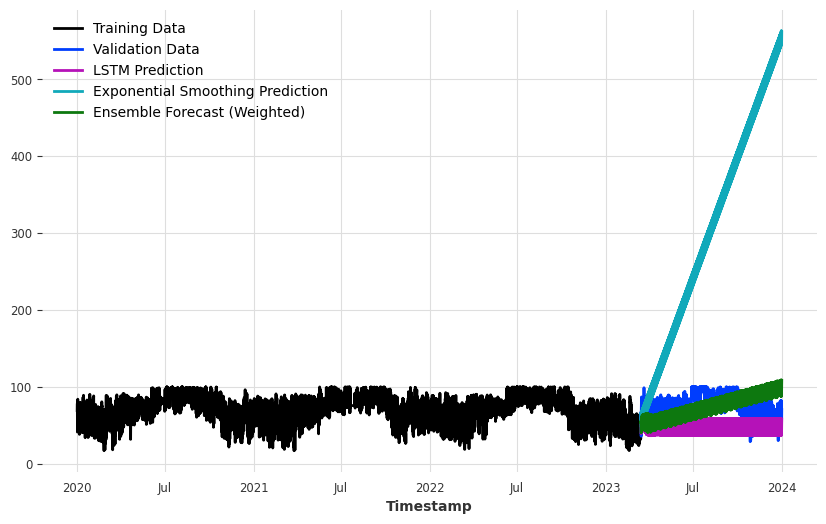

In [ ]:
plt.figure(figsize=(10, 6))
train.plot(label='Training Data')
val.plot(label='Validation Data')
lstm_prediction.plot(label='LSTM Prediction')
exp_prediction.plot(label='Exponential Smoothing Prediction')
ensemble_prediction.plot(label='Ensemble Forecast (Weighted)')
plt.legend()
plt.show()

In [ ]:
mae_error = mae(val, ensemble_prediction)
rmse_value = rmse(val, ensemble_prediction)

print(f'Weighted Ensemble MAE: {mae_error:.2f}')
print(f'Weighted Ensemble RMSE: {rmse_value:.2f}')

Weighted Ensemble MAE: 17.92
Weighted Ensemble RMSE: 22.28


In [ ]:
val_df = val.pd_dataframe()
ensemble_prediction_df = ensemble_prediction.pd_dataframe()

print("Actual Results:")
print(val_df.head())

print("\nEnsemble Predicted Results:")
print(ensemble_prediction_df.head())

print("Actual Results:")
print(val_df)

print("\nEnsemble Predicted Results:")
print(ensemble_prediction_df)

Actual Results:
component               RH (%)
Timestamp                     
2023-03-14 18:00:00  60.920000
2023-03-14 19:00:00  60.683333
2023-03-14 20:00:00  62.285000
2023-03-14 21:00:00  62.585000
2023-03-14 22:00:00  60.015000

Ensemble Predicted Results:
component               RH (%)
Timestamp                     
2023-03-14 18:00:00  53.733832
2023-03-14 19:00:00  54.949875
2023-03-14 20:00:00  55.543177
2023-03-14 21:00:00  55.944857
2023-03-14 22:00:00  56.023997
Actual Results:
component               RH (%)
Timestamp                     
2023-03-14 18:00:00  60.920000
2023-03-14 19:00:00  60.683333
2023-03-14 20:00:00  62.285000
2023-03-14 21:00:00  62.585000
2023-03-14 22:00:00  60.015000
...                        ...
2023-12-31 19:00:00  66.005000
2023-12-31 20:00:00  63.002500
2023-12-31 21:00:00  65.645000
2023-12-31 22:00:00  67.382500
2023-12-31 23:00:00  70.533333

[7014 rows x 1 columns]

Ensemble Predicted Results:
component                RH (%)
Timestamp       